In [ ]:
import pandas as pd

In [ ]:
url = "https://yfiua.github.io/index-constituents/constituents-ftse100.csv"
df = pd.read_csv(url)

In [ ]:
symbols = []
for symbol in symbols_df['Symbol']:
    if symbol == 'BT/A.L':
        clean_symbol = 'BT-A.L'
    else:
        clean_symbol = symbol.replace('/', '.')
        if '..' in clean_symbol:
            clean_symbol = clean_symbol.replace('..', '.')
    symbols.append(clean_symbol)

all_data = pd.DataFrame()

for symbol in symbols:
    stock_data = yf.download(symbol, start="2020-01-01", end="2025-02-01")
    stock_data['Symbol'] = symbol
    all_data = pd.concat([all_data, stock_data])

all_data = all_data.reset_index()
all_data.to_parquet('../../data/raw/ftse_daily_raw.parquet')

In [ ]:
import pandas as pd
import json

def process_data():
    df = pd.read_parquet('../../data/raw/ftse_daily_raw.parquet')
    
    results = []
    unique_tickers = sorted(set(col[1] for col in df.columns if isinstance(col, tuple) and col[1]))
    
    index_counter = {}
    
    for ticker in unique_tickers:
        index_counter[ticker] = 0
        
        date_data = df[('Date', '')]
        close_data = df[('Close', ticker)]
        high_data = df[('High', ticker)]
        low_data = df[('Low', ticker)]
        open_data = df[('Open', ticker)]
        volume_data = df[('Volume', ticker)]
        
        mask = pd.notna(close_data)
        valid_indices = mask[mask].index
        
        dates = pd.to_datetime(date_data[valid_indices], unit='ns')
        sorted_indices = [x for _, x in sorted(zip(dates, valid_indices))]
        
        for idx in sorted_indices:
            entry = {
                'symbol': ticker,
                'date': pd.to_datetime(date_data.iloc[idx], unit='ns').strftime('%Y-%m-%d'),
                'open': float(open_data.iloc[idx]),
                'high': float(high_data.iloc[idx]),
                'low': float(low_data.iloc[idx]),
                'close': float(close_data.iloc[idx]),
                'volume': int(volume_data.iloc[idx]),
                '__index_level_0__': index_counter[ticker]
            }
            index_counter[ticker] += 1
            results.append(entry)
    
    final_df = pd.DataFrame(results)
    final_df.to_parquet('../../data/raw/ftse_daily.parquet', index=False)

process_data()

In [ ]:
df = pd.read_parquet('../../data/raw/ftse_daily.parquet')

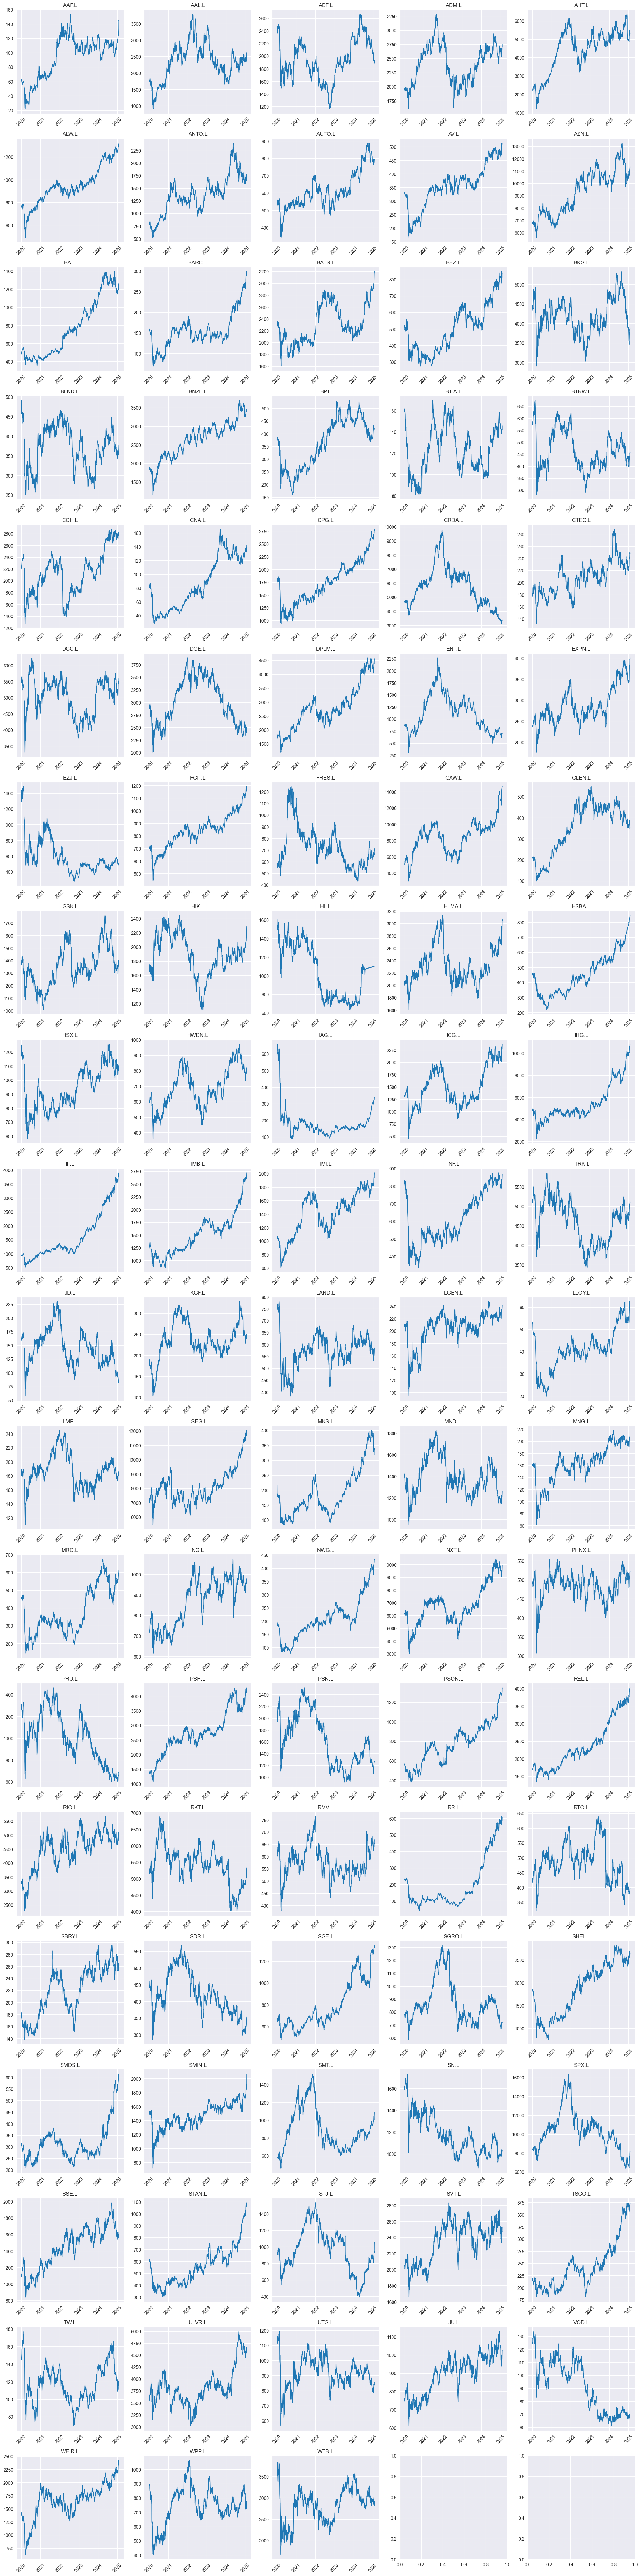

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import math

def plot_all_stocks(df):
    symbols = df['symbol'].unique()
    n = len(symbols)
    cols = 5
    rows = math.ceil(n / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(20, 4 * rows))
    axs = axs.ravel()

    for idx, symbol in enumerate(symbols):
        data = df[df['symbol'] == symbol]
        axs[idx].plot(pd.to_datetime(data['date']), data['close'])
        axs[idx].set_title(symbol)
        axs[idx].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


plot_all_stocks(df)